In [17]:
!pip install datasets stanza

In [18]:
!pip install transformers

In [29]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 6.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp310-cp310-linux_x86_64.whl size=4296187 sha256=d3b1ccc1bccf2bc2ff87af0d860112bc1dd35395a02c73f73d45915d47fb5e47
  Stored in directory: /root/.cache/pip/wheels/0d/a2/00/81db54d3e6a8199b829d58e02cec2ddb20ce3e59fad8d3c92a
Successfully built fasttext


In [19]:
from datasets import load_dataset

dataset = load_dataset("Overfit-GM/turkish-toxic-language")

dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'target', 'source', 'is_toxic'],
        num_rows: 77800
    })
})

In [30]:
# ignore unnecessary warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# numpy and pandas for process and analyze
import pandas as pd
import numpy as np

# nltk for stopwords and stemmer
from nltk.corpus import stopwords
import nltk
from nltk.stem import PorterStemmer

#re for clean special char
import re

# stanza for NLP preprocessing
!pip install stanza
import stanza

# sklearn libraries for models and evaulation metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

# transformers libraries for NLP model training and evaluation
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments

# pytorch library for data handling, model training, and loss computation
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn import CrossEntropyLoss

# matpilotlib and seaborn libraries for visualize
import matplotlib.pyplot as plt
import seaborn as sns

# progress bar for data processing
from tqdm import tqdm

from google.colab import drive
drive.mount('/content/drive')

#fasttext for model training
import fasttext

# install and download stanza's turkish model
stanza.download("tr", verbose=False)
print("Stanza Turkish model downloaded!")

nlp = stanza.Pipeline("tr", use_gpu=True)

print("Libraries and NLTK datasets loaded!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Stanza Turkish model downloaded!
Libraries and NLTK datasets loaded!


In [21]:
nltk.download("stopwords")
stop_words = set(stopwords.words("turkish"))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [22]:
# function: remove special char
def remove_special_characters(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'[\U00010000-\U0010FFFF]', '', text)
    return text

# preprocessing function
def preprocess_text_stanza(text):
    text = remove_special_characters(text.lower())

    doc = nlp(text)
    processed_tokens = []

    for sentence in doc.sentences:
        for word in sentence.words:
            if word.text.isalpha() and word.text not in stop_words:
                if word.lemma is not None:
                    processed_tokens.append(word.lemma)
                else:
                    processed_tokens.append(word.text[:5] if len(word.text) > 5 else word.text)

    return " ".join(processed_tokens)

print("Preprocessing dataset...")
tqdm.pandas()

train = dataset['train']
train = train.to_pandas()
train["cleaned_text"] = train["text"].progress_apply(preprocess_text_stanza)

train

Preprocessing dataset...


100%|██████████| 77800/77800 [2:22:49<00:00,  9.08it/s]


,text,target,source,is_toxic,cleaned_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1,phil spector bir lanet katil ol bil ben tıpkı ...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1,la sik git amk pozitif sik kafa ülke ana dikil...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,ol iste ja rul bir tupac shakur ol iste çoğu z...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,yap gerek ara sonra sayfa bak gör kölelik din ...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,kabul dream chaser program ilgili ol çok kal m
...,...,...,...,...,...
77795,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,isim kısal kut kendi baş bir sayfa ol i zaten ...
77796,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,ecek i marta kadar incele goru dusun hazine ba...
77797,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,INSULT,jigsaw,1,oh adam sen sadece yumuşak bir inek saniye iç ...
77798,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,INSULT,jigsaw,1,zayıf site temizle


In [23]:
output_file = "/content/drive/My Drive/cleaned_dataset.csv"

train.to_csv(output_file, index=False, encoding="utf-8")

print(f"Cleaned dataset saved to Google Drive at {output_file}")

Cleaned dataset saved to Google Drive at /content/drive/My Drive/cleaned_dataset.csv


In [80]:
input_file = "/content/drive/My Drive/cleaned_dataset.csv"

train = pd.read_csv(input_file, encoding="utf-8")

train

,text,target,source,is_toxic,cleaned_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1,phil spector bir lanet katil ol bil ben tıpkı ...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1,la sik git amk pozitif sik kafa ülke ana dikil...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,ol iste ja rul bir tupac shakur ol iste çoğu z...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,yap gerek ara sonra sayfa bak gör kölelik din ...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,kabul dream chaser program ilgili ol çok kal m
...,...,...,...,...,...
77795,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,isim kısal kut kendi baş bir sayfa ol i zaten ...
77796,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,ecek i marta kadar incele goru dusun hazine ba...
77797,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,INSULT,jigsaw,1,oh adam sen sadece yumuşak bir inek saniye iç ...
77798,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,INSULT,jigsaw,1,zayıf site temizle


In [81]:
train = train.dropna(subset=["cleaned_text"])

def convert_turkish_to_english(text):
    turkish_to_english = str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU")
    return text.translate(turkish_to_english)

print("Expanding dataset with Turkish and English character versions...")

train_turkish = train.copy()
train_english = train.copy()
train_english.loc[:, "cleaned_text"] = train_english["cleaned_text"].progress_apply(convert_turkish_to_english)

train_expanded = pd.concat([train_turkish, train_english], ignore_index=True)

print(f"Dataset expanded. Original size: {len(train_turkish)}, Expanded size: {len(train_expanded)}")

train

Expanding dataset with Turkish and English character versions...


100%|██████████| 77792/77792 [00:00<00:00, 82516.38it/s]


Dataset expanded. Original size: 77792, Expanded size: 155584


,text,target,source,is_toxic,cleaned_text
0,Phil Spector bir lanet katil olduğunu Biliyors...,INSULT,jigsaw,1,phil spector bir lanet katil ol bil ben tıpkı ...
1,Lan siktirin gidin AMK pozitif sik kafaları Ül...,PROFANITY,told,1,la sik git amk pozitif sik kafa ülke ana dikil...
2,2pac Olmak İstiyorum Ja Rule bir Tupac Shakur ...,OTHER,jigsaw,0,ol iste ja rul bir tupac shakur ol iste çoğu z...
3,Ne yapılması gerekiyor Aradan sonra bu sayfaya...,OTHER,jigsaw,0,yap gerek ara sonra sayfa bak gör kölelik din ...
4,Kabul Dream Chaser programı ile ilgili olmayan...,OTHER,jigsaw,0,kabul dream chaser program ilgili ol çok kal m
...,...,...,...,...,...
77795,İsmi kısaltmak için her kutu kendi başına bir ...,OTHER,jigsaw,0,isim kısal kut kendi baş bir sayfa ol i zaten ...
77796,ecek acak 31 marta kadar incelenir gorusulur d...,OTHER,told,0,ecek i marta kadar incele goru dusun hazine ba...
77797,Oh adamım Sen sadece yumuşak bir ineğin Birkaç...,INSULT,jigsaw,1,oh adam sen sadece yumuşak bir inek saniye iç ...
77798,Bu zayıf siteyi temizleyeceğim hyyuyuyuyuyuyuy...,INSULT,jigsaw,1,zayıf site temizle


In [82]:
# Custom tokenizer
def fasttext_tokenizer(text):
    turkish_to_english = str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU")
    text = text.translate(turkish_to_english)
    text = text.lower()
    return text

train["fasttext_format"] = "__label__" + train["is_toxic"].astype(str) + " " + train["cleaned_text"].apply(fasttext_tokenizer)

# Save training and test data
train_file = "/content/drive/My Drive/fasttext_train.txt"
test_file = "/content/drive/My Drive/fasttext_test.txt"

train_data = train.sample(frac=0.8, random_state=42).copy()
test_data = train.drop(train_data.index).copy()

train_data["fasttext_format"].to_csv(train_file, index=False, header=False)
test_data["fasttext_format"].to_csv(test_file, index=False, header=False)

print("FastText dataset prepared and saved.")

<ipython-input-82-53a5c94cf35c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["fasttext_format"] = "__label__" + train["is_toxic"].astype(str) + " " + train["cleaned_text"].apply(fasttext_tokenizer)


FastText dataset prepared and saved.


In [83]:
model = fasttext.train_supervised(
    input=train_file,
    lr=0.1,
    epoch=25,
    wordNgrams=3,
    bucket=200000,
    dim=100,
    loss="softmax"
)

model_file = "/content/drive/My Drive/toxicity_model.bin"
model.save_model(model_file)


Classification Report:
              precision    recall  f1-score   support

   Non-Toxic       0.88      0.90      0.89      7524
       Toxic       0.91      0.88      0.89      8034

    accuracy                           0.89     15558
   macro avg       0.89      0.89      0.89     15558
weighted avg       0.89      0.89      0.89     15558



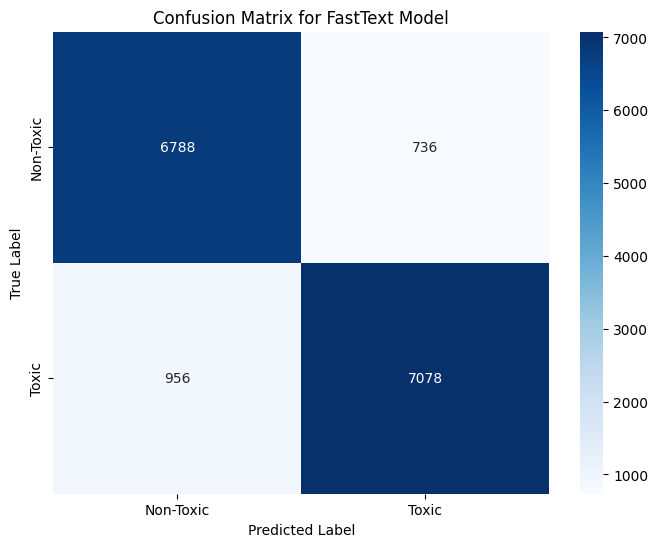

In [84]:
# classification report

model_file = "/content/drive/My Drive/toxicity_model.bin"
model = fasttext.load_model(model_file)

test_sentences = test_data["cleaned_text"].tolist()
test_labels = test_data["is_toxic"].tolist()

predictions = [int(model.predict(sentence)[0][0].replace("__label__", "")) for sentence in test_sentences]

print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=["Non-Toxic", "Toxic"]))

# confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

# visualization
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Non-Toxic", "Toxic"], yticklabels=["Non-Toxic", "Toxic"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for FastText Model")
plt.show()

In [85]:
# test sırasında ve modele text verirken aynı tokenizerı kullanmak zorunludur
def fasttext_tokenizer(text):
    turkish_to_english = str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU")
    text = text.translate(turkish_to_english)
    text = text.lower()
    return text

def test_fasttext_model(model, sentences, tokenizer):
    predictions = []
    for sentence in sentences:
        processed_sentence = tokenizer(sentence)
        prediction = model.predict(processed_sentence)[0][0].replace("__label__", "")
        predictions.append((sentence, prediction))
    return predictions

# testing
test_sentences = [
    "Sen bir aptalsın!",
    "sen bir aptalsin",
    "Sen bir aptalsin!",
    "bu tamamen zararsiz bir cümle.",
    "Bugün hava çok güzel.",
    "Kes lan sesini",
    "Naber lan",
    "naber kanka",
    "nasılsın",
    "aga bu modeli nasıl eğiteceğiz ya",
    "senin anan toxic",
    "güzel günler mazide kaldı",
    "kanka ve lan her türlü toxic oluyor",
    "dataset ile ilgili galiba",
    "neyse olduğu kadar"
]

model_file = "/content/drive/My Drive/toxicity_model.bin"
model = fasttext.load_model(model_file)

print("Testing FastText Model:")
results = test_fasttext_model(model, test_sentences, fasttext_tokenizer)

for sentence, prediction in results:
    label = "Toxic" if prediction == "1" else "Non-Toxic"
    print(f"Sentence: {sentence}\nPrediction: {label}\n")


Testing FastText Model:
Sentence: Sen bir aptalsın!
Prediction: Toxic

Sentence: sen bir aptalsin
Prediction: Toxic

Sentence: Sen bir aptalsin!
Prediction: Toxic

Sentence: bu tamamen zararsiz bir cümle.
Prediction: Non-Toxic

Sentence: Bugün hava çok güzel.
Prediction: Non-Toxic

Sentence: Kes lan sesini
Prediction: Toxic

Sentence: Naber lan
Prediction: Toxic

Sentence: naber kanka
Prediction: Toxic

Sentence: nasılsın
Prediction: Non-Toxic

Sentence: aga bu modeli nasıl eğiteceğiz ya
Prediction: Toxic

Sentence: senin anan toxic
Prediction: Toxic

Sentence: güzel günler mazide kaldı
Prediction: Non-Toxic

Sentence: kanka ve lan her türlü toxic oluyor
Prediction: Toxic

Sentence: dataset ile ilgili galiba
Prediction: Non-Toxic

Sentence: neyse olduğu kadar
Prediction: Non-Toxic



In [86]:
def prepare_category_fasttext_format(row):
    label = f"__label__{row['target']}"
    return f"{label} {row['cleaned_text']}"

print("Preparing category FastText format...")
train_expanded.loc[:, "fasttext_category_format"] = train_expanded.apply(prepare_category_fasttext_format, axis=1)

category_train_file = "/content/drive/My Drive/fasttext_category_train.txt"
category_test_file = "/content/drive/My Drive/fasttext_category_test.txt"

train_category_data = train_expanded.sample(frac=0.8, random_state=42).copy()
test_category_data = train_expanded.drop(train_category_data.index).copy()

train_category_data["fasttext_category_format"].to_csv(category_train_file, index=False, header=False)
test_category_data["fasttext_category_format"].to_csv(category_test_file, index=False, header=False)

print("Category FastText dataset prepared and saved.")

Preparing category FastText format...
Category FastText dataset prepared and saved.


In [87]:
print("Training FastText category model...")
category_model = fasttext.train_supervised(
    input=category_train_file,
    lr=0.1,
    epoch=25,
    wordNgrams=3,
    bucket=200000,
    dim=100,
    loss="softmax"
)

category_model_file = "/content/drive/My Drive/category_model.bin"
category_model.save_model(category_model_file)
print(f"Category model saved to {category_model_file}")


Training FastText category model...
Category model saved to /content/drive/My Drive/category_model.bin


Evaluating category model...
Classification Report for Category Model:
              precision    recall  f1-score   support

      INSULT       0.88      0.84      0.86      4338
   PROFANITY       0.93      0.98      0.96     14961
       OTHER       0.96      0.95      0.95      7335
      RACIST       0.95      0.87      0.91      4104
      SEXIST       0.83      0.70      0.76       379

    accuracy                           0.93     31117
   macro avg       0.91      0.87      0.89     31117
weighted avg       0.93      0.93      0.93     31117



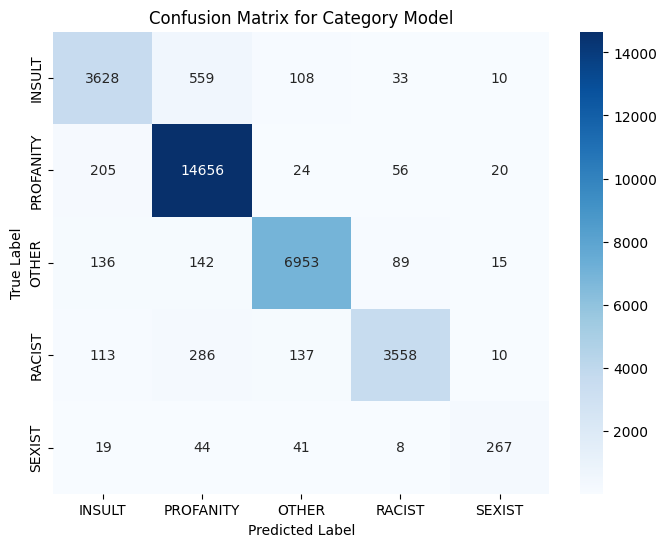

In [88]:
print("Evaluating category model...")

category_test_sentences = test_category_data["cleaned_text"].tolist()
category_test_labels = test_category_data["target"].tolist()

predicted_labels = [category_model.predict(sentence)[0][0].replace("__label__", "") for sentence in category_test_sentences]

print("Classification Report for Category Model:")
print(classification_report(category_test_labels, predicted_labels, target_names=list(train_expanded["target"].unique())))

conf_matrix = confusion_matrix(category_test_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=list(train_expanded["target"].unique()), yticklabels=list(train_expanded["target"].unique()))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for Category Model")
plt.show()


In [96]:
# Test sırasında ve modele text verirken aynı tokenizer kullanılmalıdır
def fasttext_tokenizer(text):
    turkish_to_english = str.maketrans("çğıöşüÇĞİÖŞÜ", "cgiosuCGIOSU")
    text = text.translate(turkish_to_english)
    text = text.lower()
    return text

def test_fasttext_category_model(model, sentences, tokenizer):
    predictions = []
    for sentence in sentences:
        processed_sentence = tokenizer(sentence)
        pred = model.predict(processed_sentence)
        print(f"Raw prediction: {pred}"
        prediction = pred[0][0]
        predictions.append((sentence, prediction))
    return predictions

# testing
test_sentences_category = [
    "Sen bir aptalsın!",
    "sen bir aptalsin",
    "Sen bir aptalsin!",
    "bu tamamen zararsiz bir cümle.",
    "Bugün hava çok güzel.",
    "Kes lan sesini",
    "Naber lan",
    "naber kanka",
    "nasılsın",
    "aga bu modeli nasıl eğiteceğiz ya",
    "senin anan toxic",
    "güzel günler mazide kaldı",
    "kanka ve lan her türlü toxic oluyor",
    "dataset ile ilgili galiba",
    "neyse olduğu kadar",
    "BÖYLE MODELİN AMK",
    "lana hakaret diyen kafanı sikeyim senin"
]

category_model_file = "/content/drive/My Drive/category_model.bin"
category_model = fasttext.load_model(category_model_file)

print("Testing FastText Category Model:")
results_category = test_fasttext_category_model(category_model, test_sentences_category, fasttext_tokenizer)

for sentence, prediction in results_category:
    category = {
        "__label__INSULT": "INSULT",
        "__label__PROFANITY": "PROFANITY",
        "__label__RACIST": "RACIST",
        "__label__SEXIST": "SEXIST",
        "__label__OTHER": "OTHER"
    }.get(prediction, "Unknown")
    print(f"Sentence: {sentence}\nPredicted Category: {category}\n")


Testing FastText Category Model:
Raw prediction: (('__label__INSULT',), array([1.00001001]))
Raw prediction: (('__label__INSULT',), array([1.00001001]))
Raw prediction: (('__label__INSULT',), array([1.00001001]))
Raw prediction: (('__label__OTHER',), array([0.99877608]))
Raw prediction: (('__label__OTHER',), array([1.00001001]))
Raw prediction: (('__label__INSULT',), array([0.99974269]))
Raw prediction: (('__label__INSULT',), array([0.98571771]))
Raw prediction: (('__label__INSULT',), array([0.99992871]))
Raw prediction: (('__label__OTHER',), array([1.00001001]))
Raw prediction: (('__label__OTHER',), array([0.92030948]))
Raw prediction: (('__label__PROFANITY',), array([0.99943018]))
Raw prediction: (('__label__OTHER',), array([0.99909329]))
Raw prediction: (('__label__INSULT',), array([0.59481227]))
Raw prediction: (('__label__OTHER',), array([1.00001001]))
Raw prediction: (('__label__OTHER',), array([1.00001001]))
Raw prediction: (('__label__PROFANITY',), array([1.00001001]))
Raw pred